# `XGBboost`

In [ ]:
import sys
from pathlib import Path
import joblib
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data_loader import (
    load_splits)

import time
import numpy as np
import pandas as pd

from sklearn.model_selection import  StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



FIGURES_DIR = ROOT / "reports" / "figures"

In [7]:
# Загружаю сплиты данных
data = load_splits(scaled=False,encoded_y=True)
X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

### Обучаем XGBClassifier на исходных признаках исользуя GreadSercCV

In [ ]:
xgb = XGBClassifier(
    objective="multi:sofprob",
    num_class=3,
    n_jobs=-1,
    eval_metric="mlogloss",
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "n_estimators": [200,400],
    "learning_rate": [0.01,0.1],
    "max_depth": [3,5],
    "subsample": [0.8,1.0],
    "colsample_bytree": [0.8,1.0],
    "reg_lambda": [0.1,0.2]
}

gs = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True
)


t0 = time.perf_counter()
gs.fit(X_train, y_train)
total_search_time = time.perf_counter() - t0

xgb_model = gs.best_estimator_


Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400, 'reg_lambda': 0.1, 'subsample': 0.8}
Best CV f1_macro: 0.9961092267095021
Best model refit_time_ (sec): 2.4707741737365723
Total GridSearchCV time (sec): 172.78174800000033


In [24]:
#cохраняю лучшую модель
ARTIFACTS_DIR = Path("../models").resolve()
joblib.dump(xgb_model, ARTIFACTS_DIR / "xgb_model.pkl")


['C:\\Users\\AlexK\\OneDrive\\Рабочий стол\\Классификаци типов личности\\models\\xgb_model.pkl']

In [ ]:
best_params = gs.best_params_
fit_time = gs.refit_time_

In [14]:
# Предсказание 
y_pred = xgb_model.predict(X_test)

In [17]:
# Метрики
accuracy =  accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)

In [20]:
# Важность признаков
fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)



### Топ-10 Признаков для модели
| feature | importance |
|---|---:|
| party_liking | 0.314436 |
| alone_time_preference | 0.099683 |
| public_speaking_comfort | 0.092789 |
| social_energy | 0.085059 |
| talkativeness | 0.083962 |
| excitement_seeking | 0.081230 |
| group_comfort | 0.031702 |
| reading_habit | 0.029850 |
| leadership | 0.029295 |
| adventurousness | 0.028646 |
``


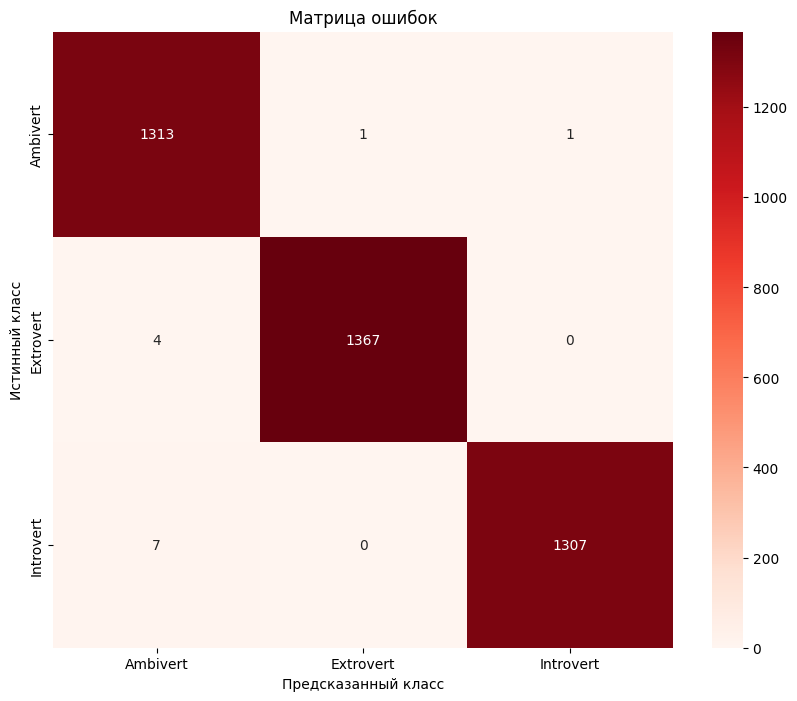

In [21]:
# Строим матрицу ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=["Ambivert", "Extrovert", "Introvert"], yticklabels=["Ambivert", "Extrovert", "Introvert"])
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок")
plt.savefig(FIGURES_DIR / "XGBoost_Confusion_matrix", dpi=300, bbox_inches='tight')

## 📌 Результаты модели XGBclassifier

### ⚙️ Лучшие гиперпараметры
| parameter | value |
|---|---:|
| colsample_bytree | 1.0 |
| learning_rate | 0.1 |
| max_depth | 3 |
| n_estimators | 400 |
| reg_lambda | 0.1 |
| subsample | 0.8 |

### ⏱️ Время переобучения (refit)
| metric | value |
|---|---:|
| refit_time_sec | 2.47 |

---

### 📊 Метрики на TEST выборке
| metric | value |
|---|---:|
| accuracy | 0.99 |
| f1_macro | 0.99 |

---

### 🧾 Classification Report
| class | precision | recall | f1-score | support |
|---:|---:|---:|---:|---:|
| Ambivert| 0.99 | 1.00 | 1.00 | 1315 |
| Extrovert | 1.00 | 1.00 | 1.00 | 1371 |
| Introvert | 1.00 | 0.99 | 1.00 | 1314 |
| **accuracy** |  |  | **1.00** | **4000** |
| **macro avg** | **1.00** | **1.00** | **1.00** | **4000** |
| **weighted avg** | **1.00** | **1.00** | **1.00** | **4000** |


### Модель демонстрирует 12 неправильных предсказаний из 4000; ошибки редки и в основном между Ambivert ↔ (Extrovert/Introvert).
